In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import imagehash
from PIL import Image

import tensorflow as tf

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions as keras_decode_predictions
from tensorflow.keras.preprocessing import image as keras_image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics.pairwise import cosine_similarity

import sys 
import os
from pathlib import Path

# Working with Images Lab
## Information retrieval, preprocessing, and feature extraction

In this lab, you'll work with images of felines (cats), which have been classified according to their taxonomy. Each subfolder contains images of a particular species. The dataset is located [here](https://www.kaggle.com/datasets/datahmifitb/felis-taxonomy-image-classification) but it's also provided to you in the `data/` folder.

### Problem 1. Some exploration (1 point)
How many types of cats are there? How many images do we have of each? What is a typical image size? Are there any outliers in size?

In [12]:
# To get the type of cats all we need to do is see how many folders we have in the data directory, since they are already classified.

entries = os.listdir('./data')
print(f'{len(entries)} types of cats')
# We see that we have 3 types of cats

10 types of cats


In [13]:
# To see how many images we have of each we have to iterate trough each folder... I will use Path from pathlib for this.
folder_images = {}
parent_dir = Path('./data')
for subfolder in parent_dir.iterdir():
    if subfolder.is_dir():
        folder_images[subfolder.name] = len(list(subfolder.glob('*.jpg')))

folder_images

{'african-wildcat': 80,
 'blackfoot-cat': 74,
 'chinese-mountain-cat': 35,
 'domestic-cat': 58,
 'european-wildcat': 53,
 'features': 0,
 'jungle-cat': 78,
 'preprocessed_batches': 0,
 'preprocessed_batches_grayscale': 0,
 'sand-cat': 65}

In [ ]:
# To see the typical image size I will get all images and get the mean.
image_sizes = []
for subfolder in parent_dir.iterdir():
    if subfolder.is_dir():
        for image in subfolder.glob('*.jpg'):
            img = plt.imread(image)
            # Convert to from bytes to kilobytes
            image_sizes.append(img.nbytes / 1024)
# Now we get the mean
np.mean(image_sizes)
# Since the outliers are quite big, we can remove them to get a more realistic mean.
image_sizes_cleaned = [size for size in image_sizes if size >= 10000]
np.mean(image_sizes_cleaned)

# Hm, the size amount seems to be quite a lot bigger than the amounts i see in File Expolorer. Wonder why that it.
# After a little research I found that File Explorer shows compressed file sizes, so when we load images in python it gets decompressed into the full array, that's why we see a difference.

28696.638427734375

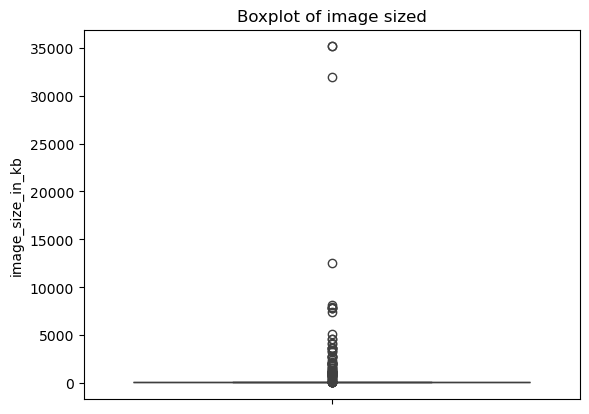

In [15]:
# Now.. to get the outliers, I will create a DataFrame with the image sizes and then use seaborn to visualize it.
image_sizes = pd.DataFrame(image_sizes, columns=['image_size_in_kb'])
sns.boxplot(image_sizes['image_size_in_kb'])
plt.title("Boxplot of image sized")
plt.show()

# We see that we have some outliers, if it was up to me, I'd say anything above 10000kb is an outlier in this case. Which would mean we have 3 outliers.

### Problem 2. Duplicat(e)s (1 point)
Find a way to filter out (remove) identical images. I would recommnend using file hashes, but there are many approaches. Keep in mind that during file saving, recompression, etc., a lot of artifacts can change the file content (bytes), but not visually.

In [16]:
# Let's try using hashes...
def hash_file(filepath, algo='sha256'):
    hash_func = hashlib.new(algo)
    with open(filepath, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b''):
            hash_func.update(chunk)
    return hash_func.hexdigest()

def find_duplicate_images(folder_path):
    hashes = {}
    duplicates = []

    for folder in Path(folder_path).iterdir():
        if not folder.is_dir():
            continue
        for file in folder.glob('*.jpg'):
            file_hash = hash_file(file)
            if file_hash in hashes:
                duplicates.append((file, hashes[file_hash]))
            else:
                hashes[file_hash] = file

        return duplicates

duplicates = find_duplicate_images('./data')
duplicates # = []

# As I thought this wont work because no image is really the same, they all have different filters, watermarks, sizes,. etc.


[]

In [17]:
# We will need to change strategy. Let's use perceptual hashing instead, that way we can tell if how similar the pictures need to be, in order for us to consider them duplicates.
def find_similar_images(folder_path, hashfunc=imagehash.phash, treshold = 5):
    hashes = {}
    duplicates = []

    for folder in Path(folder_path).iterdir():
        if not folder.is_dir():
            continue
        for file in folder.glob('*.jpg'):
            img = Image.open(file)
            img_hash = hashfunc(img)

            found_duplicates = False
            for h, f in hashes.items():
                if img_hash - h <= treshold:
                    duplicates.append((file.name, f.name))
                    found_duplicates = True
                    break
            if not found_duplicates:
                hashes[img_hash] = file
    
    return duplicates

dupes = find_similar_images('./data')
dupes

# Okay, this time it worked.
# The way perceptual hashing works is that the image is being converted ot an 8x8 array of bits. First rezied to 32x32 and then converted to grayscale. We are not looking for details,
# we are looking for the general shape of the image, so we can compare it to other images. The treshold is the amount of difference (in bits) we allow between images.
# My treshold of 5 means in those 64 bits we allot a difference of 5, which is approximately 7.8% difference.

[]

In [18]:
# Now to remove them we will simply tweak the function a little so it removes the file when it is a duplicate instead of adding it to our list.
def remove_similar_images(folder_path, hashfunc=imagehash.phash, treshold = 5):
    hashes = {}
    removed_files = []

    for folder in Path(folder_path).iterdir():
        if not folder.is_dir():
            continue
        for file in folder.glob('*.jpg'):
            img = Image.open(file)
            img_hash = hashfunc(img)

            found_duplicates = False
            for h, f in hashes.items():
                if img_hash - h <= treshold:
                    # Here is out change
                    os.remove(file)
                    removed_files.append(file.name)
                    found_duplicates = True
                    break
            if not found_duplicates:
                hashes[img_hash] = file
    
    return removed_files

removed_files = remove_similar_images('./data')
removed_files

# After removing duplicates I see that we still have some similar images (ones where we have a watermark below) which are not removed, so I will try to increase the treshold a little.
removed_files = remove_similar_images('./data', treshold=10)
removed_files

# Well, seems like perceptual hashing is not good enough to catch watermarks, I will try a different techinique in the future if I have time.

[]

### Problem 3. Loading a model (2 points)
Find a suitable, trained convolutional neural network classifier. I recommend `ResNet50` as it's small enough to run well on any machine and powerful enough to make reasonable predictions. Most ready-made classifiers have been trained for 1000 classes.

You'll need to install libraries and possibly tinker with configurations for this task. When you're done, display the total number of layers and the total number of parameters. For ResNet50, you should expect around 50 layers and 25M parameters.

In [19]:
model = ResNet50(weights='imagenet')

model.summary(), len(model.layers)

# Total params: 25,636,712
# Total layers: 177

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

(None, 177)

### Problem 4. Prepare the images (1 point)
You'll need to prepare the images for passing to the model. To do so, they have to be resized to the same dimensions. Most available models have a specific requirement for sizes. You may need to do additional preprocessing, depending on the model requirements. These requirements should be easily available in the model documentation.

In [20]:
# In the model documentation we see that takes an input (None, 224, 224, 3), The None is the batch size. We see that the input shape is 224x224 pixels and 3 channels (RGB).
# So using TensorFlow's 'image' we can directly load an image and specify a target size.
# Then after some image processing, adding a batch dimension and using the model.predict(), we get the predictions.
img = keras_image.load_img('./data/african-wildcat/af (1).jpg', target_size=(224, 224))
img_array = keras_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_preprocessed = preprocess_input(img_array)
predictions = model.predict(img_preprocessed)

print(keras_decode_predictions(predictions, top=3)[0])
# The model predicted that the picture is of a Lynx, which is actualyl wrong lol.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[('n02127052', 'lynx', 0.769902), ('n02129165', 'lion', 0.121595204), ('n02128385', 'leopard', 0.04657259)]


In [21]:
#Let's try a different image.
img = keras_image.load_img('./data/african-wildcat/af (8).jpg', target_size=(224, 224))
img_array = keras_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_preprocessed = preprocess_input(img_array)
predictions = model.predict(img_preprocessed)

print(keras_decode_predictions(predictions, top=3))

# This time the guess was an egyptian cat.. which is almost correct, but I will give it a pass.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[[('n02124075', 'Egyptian_cat', 0.61648333), ('n02123045', 'tabby', 0.24238078), ('n02123159', 'tiger_cat', 0.09675258)]]


In [22]:
# I feel like I kind of skipped the purpose of this task... here is how to load and resize an image without keras.
img = Image.open('./data/african-wildcat/af (8).jpg')
img_resized = img.resize((224, 224))
img_resized.show()

### Problem 5. Load the images efficiently (1 point)
Now that you've seen how to prepare the images for passing to the model... find a way to do it efficiently. Instead of loading the entire dataset in the RAM, read the images in batches (e.g. 4 images at a time). The goal is to read these, preprocess them, maybe save the preprocessed results in RAM.

If you've already done this in one of the previous problems, just skip this one. You'll get your point for it.

\* Even better, save the preprocessed image arrays (they will not be valid .jpg file) as separate files, so you can load them "lazily" in the following steps. This is a very common optimization to work with large datasets.

In [23]:
# First I will create functions to save those resized images in batches with labels as seperate files, and then one to lazy load them.
def resize_and_save_batches_with_labels(batch_size=4, save_dir='./data/preprocessed_batches'):
    os.makedirs(save_dir, exist_ok=True)
    batch = []
    labels = []
    batch_index = 0

    for folder in sorted(Path('./data').iterdir()):  # ensure consistent order
        if folder.is_dir():
            label = folder.name
            for file in sorted(folder.glob('*.jpg')):
                img = Image.open(file).convert('RGB')
                img_resized = img.resize((224, 224))
                img_array = np.array(img_resized)
                batch.append(img_array)
                labels.append(label)

                if len(batch) == batch_size:
                    batch_array = np.stack(batch)
                    label_array = np.array(labels)
                    
                    np.save(os.path.join(save_dir, f'batch_{batch_index:04d}.npy'), batch_array)
                    np.save(os.path.join(save_dir, f'labels_{batch_index:04d}.npy'), label_array)
                    
                    print(f'Saved batch_{batch_index:04d}.npy and labels_{batch_index:04d}.npy')
                    batch = []
                    labels = []
                    batch_index += 1

    if batch:
        batch_array = np.stack(batch)
        label_array = np.array(labels)
        
        np.save(os.path.join(save_dir, f'batch_{batch_index:04d}.npy'), batch_array)
        np.save(os.path.join(save_dir, f'labels_{batch_index:04d}.npy'), label_array)
        
        print(f'Saved batch_{batch_index:04d}.npy and labels_{batch_index:04d}.npy')


def lazy_load_batches_with_labels(batch_dir):
    for batch_file in sorted(Path(batch_dir).glob('batch_*.npy')):
        batch_array = np.load(batch_file)
        label_file = batch_file.name.replace('batch_', 'labels_')
        label_array = np.load(Path(batch_dir) / label_file)
        yield batch_array, label_array

resize_and_save_batches_with_labels()


Saved batch_0000.npy and labels_0000.npy
Saved batch_0001.npy and labels_0001.npy
Saved batch_0002.npy and labels_0002.npy
Saved batch_0003.npy and labels_0003.npy
Saved batch_0004.npy and labels_0004.npy
Saved batch_0005.npy and labels_0005.npy
Saved batch_0006.npy and labels_0006.npy
Saved batch_0007.npy and labels_0007.npy
Saved batch_0008.npy and labels_0008.npy
Saved batch_0009.npy and labels_0009.npy
Saved batch_0010.npy and labels_0010.npy
Saved batch_0011.npy and labels_0011.npy
Saved batch_0012.npy and labels_0012.npy
Saved batch_0013.npy and labels_0013.npy
Saved batch_0014.npy and labels_0014.npy
Saved batch_0015.npy and labels_0015.npy
Saved batch_0016.npy and labels_0016.npy
Saved batch_0017.npy and labels_0017.npy
Saved batch_0018.npy and labels_0018.npy
Saved batch_0019.npy and labels_0019.npy
Saved batch_0020.npy and labels_0020.npy
Saved batch_0021.npy and labels_0021.npy
Saved batch_0022.npy and labels_0022.npy
Saved batch_0023.npy and labels_0023.npy
Saved batch_0024

### Problem 6. Predictions (1 point)
Finally, you're ready to get into the meat of the problem. Obtain predictions from your model and evaluate them. This will likely involve manual work to decide how the returned classes relate to the original ones.

Create a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) to evaluate the classification.

In [24]:
# First lets create lists to store the labels of the predictions and actual names, then fill them before creating the confusion matrix.
all_prediction_labels = []
all_actual_labels = []

for batch, labels in lazy_load_batches_with_labels('./data/preprocessed_batches'):
    predictions = model.predict(preprocess_input(batch))
    decoded = keras_decode_predictions(predictions, top=1)

    for pred, actual in zip(decoded, labels):
        predicted_label = pred[0][1]  # Top-1 prediction label
        all_prediction_labels.append(predicted_label)
        all_actual_labels.append(actual)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

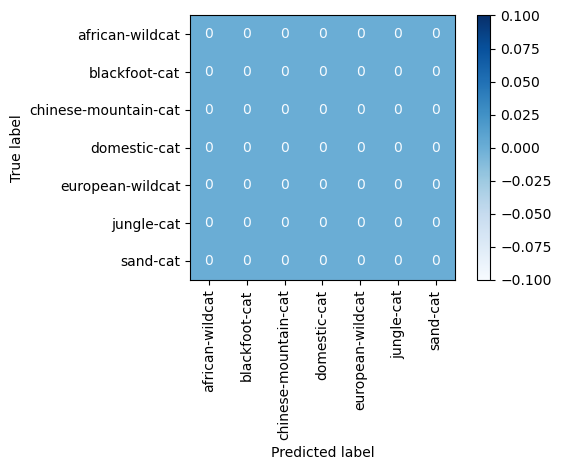

In [25]:
# Then let's create the confusion matrix.
cm = confusion_matrix(all_actual_labels, all_prediction_labels, labels=sorted(set(all_actual_labels)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(all_actual_labels)))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.tight_layout()
plt.show()

# Welp... not the results we were expecting. The model is not very good at classifying cats, but it was close enough.

### Problem 7. Grayscale (1 point)
Converting the images to grayscale should affect the classification negatively, as we lose some of the color information.

Find a way to preprocess the images to grayscale (using what you already have in Problem 4 and 5), pass them to the model, and compare the classification results to the previous ones.

In [26]:
# I will reuse my previous functions with a small change. img.convert('RGB') -> img.convert('L')
# Then since grayscale doesnt have 3 channels, we need to add those challens to the shape.
# np.array(img_resized) -> img_array = np.stack([np.array(img_resized)] * 3, axis=-1)
def resize_and_save_batches_with_labels_grayscale(batch_size=4, save_dir='./data/preprocessed_batches_grayscale'):
    os.makedirs(save_dir, exist_ok=True)
    batch = []
    labels = []
    batch_index = 0

    for folder in sorted(Path('./data').iterdir()):  # ensure consistent order
        if folder.is_dir():
            label = folder.name
            for file in sorted(folder.glob('*.jpg')):
                img = Image.open(file).convert('L')
                img_resized = img.resize((224, 224))
                img_array = np.stack([np.array(img_resized)] * 3, axis=-1)  # Convert to 3 channels
                batch.append(img_array)
                labels.append(label)

                if len(batch) == batch_size:
                    batch_array = np.stack(batch)
                    label_array = np.array(labels)
                    
                    np.save(os.path.join(save_dir, f'batch_{batch_index:04d}.npy'), batch_array)
                    np.save(os.path.join(save_dir, f'labels_{batch_index:04d}.npy'), label_array)
                    
                    print(f'Saved batch_{batch_index:04d}.npy and labels_{batch_index:04d}.npy')
                    batch = []
                    labels = []
                    batch_index += 1

    if batch:
        batch_array = np.stack(batch)
        label_array = np.array(labels)
        
        np.save(os.path.join(save_dir, f'batch_{batch_index:04d}.npy'), batch_array)
        np.save(os.path.join(save_dir, f'labels_{batch_index:04d}.npy'), label_array)
        
        print(f'Saved batch_{batch_index:04d}.npy and labels_{batch_index:04d}.npy')

resize_and_save_batches_with_labels_grayscale()


Saved batch_0000.npy and labels_0000.npy
Saved batch_0001.npy and labels_0001.npy
Saved batch_0002.npy and labels_0002.npy
Saved batch_0003.npy and labels_0003.npy
Saved batch_0004.npy and labels_0004.npy
Saved batch_0005.npy and labels_0005.npy
Saved batch_0006.npy and labels_0006.npy
Saved batch_0007.npy and labels_0007.npy
Saved batch_0008.npy and labels_0008.npy
Saved batch_0009.npy and labels_0009.npy
Saved batch_0010.npy and labels_0010.npy
Saved batch_0011.npy and labels_0011.npy
Saved batch_0012.npy and labels_0012.npy
Saved batch_0013.npy and labels_0013.npy
Saved batch_0014.npy and labels_0014.npy
Saved batch_0015.npy and labels_0015.npy
Saved batch_0016.npy and labels_0016.npy
Saved batch_0017.npy and labels_0017.npy
Saved batch_0018.npy and labels_0018.npy
Saved batch_0019.npy and labels_0019.npy
Saved batch_0020.npy and labels_0020.npy
Saved batch_0021.npy and labels_0021.npy
Saved batch_0022.npy and labels_0022.npy
Saved batch_0023.npy and labels_0023.npy
Saved batch_0024

In [27]:
# Then I will store and load them... just like before. This time we use the grayscale folder tho.
all_prediction_labels_grayscacle = []
all_actual_labels_graysccale = []

for batch, labels in lazy_load_batches_with_labels('./data/preprocessed_batches_grayscale'):
    predictions = model.predict(preprocess_input(batch))
    decoded = keras_decode_predictions(predictions, top=1)

    for pred, actual in zip(decoded, labels):
        predicted_label = pred[0][1]  # Top-1 prediction label
        all_prediction_labels_grayscacle.append(predicted_label)
        all_actual_labels_graysccale.append(actual)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

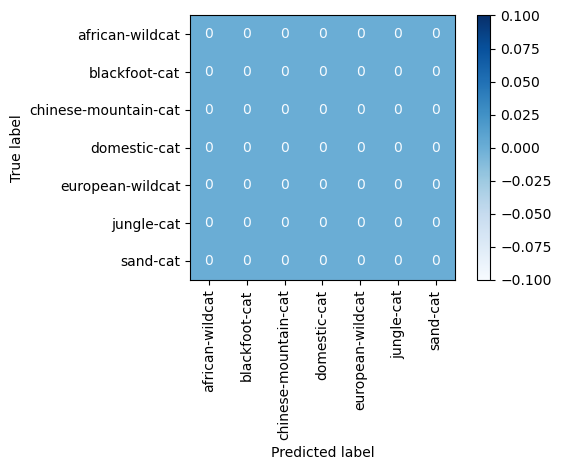

In [28]:
# And then show the confusion matrix.

cm = confusion_matrix(all_actual_labels_graysccale, all_prediction_labels_grayscacle, labels=sorted(set(all_actual_labels_graysccale)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(set(all_actual_labels_graysccale)))
disp.plot(xticks_rotation=90, cmap='Blues')
plt.tight_layout()
plt.show()

# Welp, sadly that didnt change anything, it still has 0 correct guesses.
# Maybe I messed somewhere in the beginning, I will take a look when I have time.

### Problem 8. Deep image features (1 point)
Find a way to extract one-dimensional vectors (features) for each (non-grayscale) image, using your model. This is typically done by "short-circuiting" the model output to be an intermediate layer, while keeping the input the same. 

In case the outputs (also called feature maps) have different shapes, you can flatten them in different ways. Try to not create huge vectors; the goal is to have a relatively short sequence of numbers which describes each image.

You may find a tutorial like [this](https://towardsdatascience.com/exploring-feature-extraction-with-cnns-345125cefc9a) pretty useful but note your implementation will depend on what model (and framework) you've decided to use.

It's a good idea to save these as one or more files, so you'll spare yourself a ton of preprocessing.

In [29]:
# Okay so I will be using the tensorflow ResNet50.
# Seems like the second to last layer is the one returning those feature vectors since it has an output of (1, 2048).
# So I will load the model without the final classification layer and use it to extract the features.

# I will remove the final classification layer by using "include_top=False".
# Then I will use pooling='avg' to get a 1D vector of features instead of a 2D feature map.
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

counter = 0
# Model is now: Input -> ResNet backbone -> GlobalAvgPool -> Output shape (2048,)
for batch, label in lazy_load_batches_with_labels('./data/preprocessed_batches'):
    # Since I already processed the images and stored them in batches, I will not load and preprocess the images again. Plus I've done it in previous tasks too.
    batch_preprocessed = preprocess_input(batch)  # This normalizes the input as ResNet expects

    # Extract features
    features_batch = base_model.predict(batch_preprocessed)

    # Loop around all images and categories and save them.
    os.makedirs('./data/features', exist_ok=True)
    for i, feature_vector in enumerate(features_batch):
        print(f'Feature vector for {label[i]}: {feature_vector}')
        os.makedirs(f'./data/features/{label[i]}', exist_ok=True)
        np.save(f'./data/features/{label[i]}/feature_{counter}.npy', feature_vector)
        counter += 1
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Feature vector for african-wildcat: [0.03026138 0.20299771 0.         ... 0.47155938 0.         0.06192306]
Feature vector for african-wildcat: [0.         0.6605719  0.1321779  ... 0.00463865 0.         0.3481654 ]
Feature vector for african-wildcat: [0.03234902 0.19971281 0.00503029 ... 0.54529023 0.07620388 0.        ]
Feature vector for african-wildcat: [0.53257173 0.3767169  0.3904635  ... 0.01856005 0.00527548 0.37301105]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Feature vector for african-wildcat: [0.         0.18935762 0.00603333 ... 0.08742438 0.00772567 0.        ]
Feature vector for african-wildcat: [0.13347349 0.05884044 0.08931445 ... 0.22221495 0.12717883 0.01054122]
Feature vector for african-wildcat: [0.02939352 0.20913406 0.2015885  ... 0.37724888 0.36865592 0.03331211]
Feature vector for african-wildcat: [0.14334579 0.14753564 0.11853997 ... 0.10338653 0.42929676 0.01863785]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Feature vector for afr

### Problem 9. Putting deep image features to use (1 points)
Try to find similar images, using a similarity metric on the features you got in the previous problem. Two good metrics are `mean squared error` and `cosine similarity`. How do they work? Can you spot images that look too similar? Can you explain why?

\* If we were to take Fourier features (in a similar manner, these should be a vector of about the same length), how do they compare to the deep features; i.e., which features are better to "catch" similar images?

In [ ]:
# First let's create lists to store the feature vectors and their paths.
features = []
paths = []

for folder in Path('./data/features').iterdir():
    if folder.is_dir():
        for file in folder.glob('*.npy'):
            feature_vector = np.load(file)
            features.append(feature_vector)
            paths.append(file)

features = np.array(features)
paths = np.array(paths)

# Now let's define the simularity functions:

# MSE measures how different two vectors are by computing the average squared difference between each pair of elements.
# Low MSE -> vectors are similar, high MSE -> vectors are different.
def mse(x ,y):
    return np.mean((x - y) ** 2)

# Cosine similarity measures how similar the direction of two vectors is — not their magnitude.
# It ranges from -1 (opposite) to 1 (same direction).
def cosine_sim(x, y):
    return cosine_similarity(x.reshape(1, -1), y.reshape(1, -1))[0, 0]

# Now let's iterate over all features to see similarities.
with open('Similarities.txt', 'w', encoding='utf-8') as f:
    for i, vec in enumerate(features):
        for j, vec2 in enumerate(features):
            comparison_mse = mse(vec, vec2)
            comparison_cosine = cosine_sim(vec, vec2)

            f.write(f"MSE comparison pic({i}): {comparison_mse} - Cosine comparison pic({j}): {comparison_cosine} \n")

# I decided to create sort of a log file (Similarities.txt) to store the results in as I in earlier tasks I decided to go for a folder based naming approach.

### * Problem 10. Explore, predict, and evaluate further
You can do a ton of things here, at your desire. For example, how does masking different areas of the image affect classification - a method known as **saliency map** ([info](https://en.wikipedia.org/wiki/Saliency_map))? Can we detect objects? Can we significantly reduce the number of features (keeping the quality) that we get? Can we reliably train a model to predict our own classes? We'll look into these in detail in the future.